In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
import matplotlib.patches as patches
import pandas as pd
from tqdm import tqdm
import cv2
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage import feature
import pickle
from sklearn.preprocessing import StandardScaler
import random
import pickle

In [2]:
from cars_detector.utils  import read_test_frame, read_frame
from cars_detector.sampling import sampling
from cars_detector.augmentation import random_augmentation
from cars_detector.features import compute_features, compute_colors_features
from cars_detector.makebox import non_max_suppression, box_otsu
from cars_detector.splitpictures import pyramid

In [3]:
df_ground_truth = pd.read_csv('train.csv')

## Sampling of positive and negative examples

In [4]:
total_positive_samples, total_negative_samples = sampling(df_ground_truth)

100%|██████████| 2225/2225 [02:24<00:00, 15.43it/s]


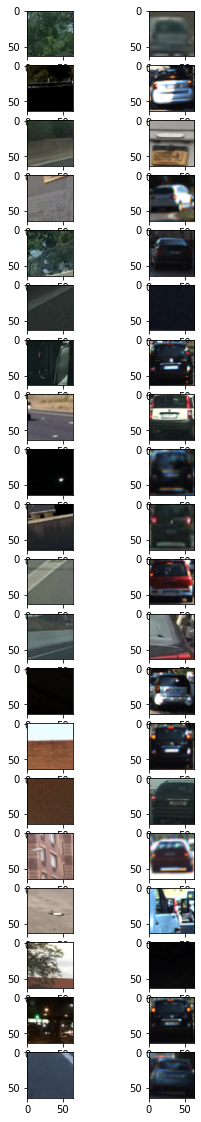

In [5]:
# samples visualisation
number_of_positive_samples = len(total_positive_samples)
number_of_negative_samples = len(total_negative_samples)
fig, ax = plt.subplots(20,2,figsize=(4, 20))
for i in range(20):
    for j in range(2):
        if j == 0:
            img = total_negative_samples[np.random.randint(number_of_negative_samples)]
        else:
            img = total_positive_samples[np.random.randint(number_of_positive_samples)]
        ax[i][j].imshow(img)

## Data Augmentation

In [6]:
new_positive_samples = []
new_negative_samples = []
thresh = 0.3
for img in tqdm(total_positive_samples, position = 0):
    r = np.random.rand(1)
    if r <= thresh:
        new_img = random_augmentation(img)
        new_positive_samples.append(new_img)

for img in tqdm(total_negative_samples, position = 0):
    r = np.random.rand(1)
    if r <= thresh:
        new_img = random_augmentation(img)
        new_negative_samples.append(new_img)

total_positive_samples.extend(new_positive_samples)
total_negative_samples.extend(new_negative_samples)

  0%|          | 0/10792 [00:00<?, ?it/s]/home/33631/cars_detection/venv/lib/python3.7/site-packages/skimage/_shared/utils.py:293: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
100%|██████████| 23968/23968 [00:02<00:00, 10583.55it/s]


In [7]:
print(f"number of positive samples: {len(total_positive_samples)}")
print(f"number of negative samples: {len(total_negative_samples)}")

number of positive samples: 14008
number of negative samples: 31135


## Compute Sift Features

In [4]:
from cv2 import SIFT_create
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances
import pickle
import numpy as np
from tqdm import tqdm

# initialise SIFT object
sift = SIFT_create()

def build_vocabulary(images_array, vocab_size = 100):
    """
    This function will sample SIFT descriptors from the training images,
    cluster them with kmeans, and then return the cluster centers.
    Args:
    -   image_paths: list of image paths.
    -   vocab_size: size of vocabulary (cluster centers)
    Returns:
    -   vocab: This is a vocab_size x d numpy array (vocabulary). Each row is a
      cluster center / visual word
    """

    dim = 128         # length of the SIFT descriptors that you are going to compute.
    features = []
    for img in tqdm(images_array, position = 0):
        try:
            kp, des_list = sift.detectAndCompute(img, None)
            for des in des_list:
                if len(des) == 128:
                    features.append(des)
        except:
            continue
    kmean = MiniBatchKMeans(vocab_size)
    kmean.fit_predict(features)
    vocab = kmean.cluster_centers_
    return np.array(vocab)

def get_bags_of_sifts_and_colors(images_array, vocab_filename, vocab_size = 100):
    # load vocabulary
    with open(vocab_filename, 'rb') as f:
        vocab = pickle.load(f)

     
    features = []
    for img in tqdm(images_array, position = 0):
        kp, des = sift.detectAndCompute(img, None)

        dists = pairwise_distances(vocab, des)
        argmin = np.argmin(dists,0)
        hist = np.bincount(argmin,minlength = vocab_size)
        hist = hist/np.sum(hist)
        colors_hist = compute_colors_features(img)
        hist = np.concatenate((hist,colors_hist))
        features.append(hist)

    return features

In [9]:
images_array = np.concatenate((total_positive_samples,total_negative_samples), axis = 0)
vocab = build_vocabulary(images_array, vocab_size = 100)
pickle.dump(vocab, open('data/vocab/vocab.pkl', 'wb'))

100%|██████████| 45143/45143 [01:26<00:00, 519.42it/s]


In [10]:
features = get_bags_of_sifts_and_colors(images_array, 'data/vocab/vocab.pkl')
pickle.dump(features, open('data/features/sift_features.pkl', 'wb'))

100%|██████████| 45143/45143 [11:42<00:00, 64.27it/s] 


## stuff Classifier: to detect stuff ...because ....euh...whatever

In [11]:
from sklearn.model_selection import train_test_split
X = features
y = np.array([1 for i in range(len(total_positive_samples))]+[0 for i in range(len(total_negative_samples))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y, shuffle = True)

# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(np.float32(X_train))
X_test = scaler.transform(np.float32(X_test))

In [12]:
clf = SVC(probability=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"accuracy: {acc}")


accuracy: 0.9171558312105438


In [13]:
pickle.dump(clf, open('data/models/svm.pkl', 'wb'))

In [14]:
# Extracts features using hog sub-sampling and make predictions
def find_cars(img, svc, X_scaler, ystart_ystop_scale, vocab, proba=0.7):
    # List of bounding box positions
    bbox_detection_list = []

    pred_array = np.zeros((img.shape[0], img.shape[1]))
       
    # Searching different size windows at different scales:
    for (ystart, ystop, scale) in ystart_ystop_scale:
        box_vis=[]
        # Crop
        ctrans_tosearch = img[ystart:ystop, :, :]
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int32(imshape[1]/scale), np.int32(imshape[0]/scale)))


        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        x_size = ctrans_tosearch.shape[1]
        y_size = ctrans_tosearch.shape[0]
        step = np.int32(40/scale)
        scale_boxes = []
        for xb in range(0, x_size, step):
            for yb in range(0, y_size, step):
                    
                xleft = np.int32(xb*scale)
                ytop = np.int32(yb*scale)

                # Extract the image patch
                try:
                    crop = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window,window))
                except:
                    continue
                # compute features
             
                features = [] 
                _, des = sift.detectAndCompute(crop, None)
                dists = pairwise_distances(vocab, des)
                argmin = np.argmin(dists,0)
                hist = np.bincount(argmin,minlength = 100)
                hist = hist/np.sum(hist)
                colors_hist = compute_colors_features(crop)
                features = np.concatenate((hist,colors_hist))

                # Scale features and make a prediction
                test_features = X_scaler.transform([features])    

                # Make prediction based on trained model 
                test_prediction = svc.predict_proba(test_features)[0][1]
                

                if test_prediction >= proba:
                    xbox_left = np.int32(xleft*scale)
                    ytop_draw = np.int32(ytop*scale)
                    win_draw = np.int32(window*scale)
                    # Append Detection Position to list 
                    bbox_detection_list.append([xbox_left,ytop_draw+ystart,win_draw,win_draw])
                    pred_array[ytop_draw+ystart:ytop_draw+ystart+win_draw, xbox_left:xbox_left+win_draw] += 1

    return bbox_detection_list, pred_array

## Cars detection

In [15]:
def bounding_boxes_to_mask(bounding_boxes, H, W):
    
    """
    Converts set of bounding boxes to a binary mask
    """

    mask = np.zeros((H, W))
    for x, y, dx, dy in bounding_boxes:
        mask[y:y+dy, x:x+dx] = 1

    return mask

def run_length_encoding(mask):

    """
    Produces run length encoding for a given binary mask
    """
    
    # find mask non-zeros in flattened representation
    non_zeros = np.nonzero(mask.flatten())[0]
    padded = np.pad(non_zeros, pad_width=1, mode='edge')
    
    # find start and end points of non-zeros runs
    limits = (padded[1:] - padded[:-1]) != 1
    starts = non_zeros[limits[:-1]]
    ends = non_zeros[limits[1:]]
    lengths = ends - starts + 1

    return ' '.join(['%d %d' % (s, l) for s, l in zip(starts, lengths)])

In [16]:
from skimage.io import imread
import copy
def compute_all_boxes():
    boxes_dict = dict()
    pred_array_dict = dict()
    submission_df = pd.read_csv('sample_submission.csv')
    submission_df = submission_df.drop(index = [0])
    for i in tqdm(range(1,203), position=0):
        img = imread('./test/'+str(i).zfill(3)+'.jpg')
        ystart_ystop_scale = [(200, 450, 1),(200, 450, 2),(200, 450, 4)]
        (bboxes, pred_array) = find_cars(img, clf, scaler, ystart_ystop_scale, vocab, proba=0.9)
        boxes_dict[i] = np.array(bboxes)
        pred_array_dict[i] = pred_array

    return(boxes_dict, pred_array_dict)

In [17]:
boxes_dict, pred_array_dict = compute_all_boxes()
pickle.dump(boxes_dict,open("data/features/boxes_dict.pkl", 'wb'))
pickle.dump(pred_array_dict,open("data/features/pred_array_dict.pkl", 'wb'))

100%|██████████| 202/202 [28:00<00:00,  8.32s/it]


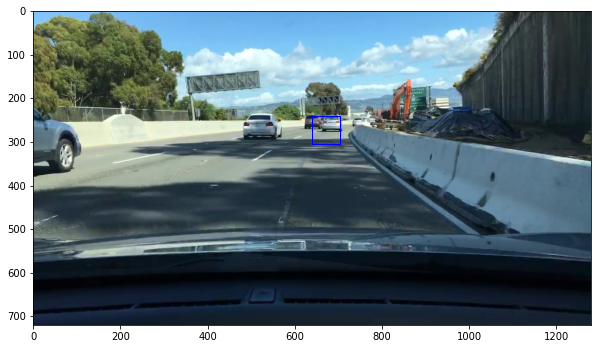

In [20]:
i = 5
img1 = imread('./test/'+str(i).zfill(3)+'.jpg')

boxes = boxes_dict[i]
fig, ax = plt.subplots(figsize=(10, 8))
for x, y, dx, dy in boxes:

    rect = patches.Rectangle((x, y), dx, dy, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
ax.imshow(img1)

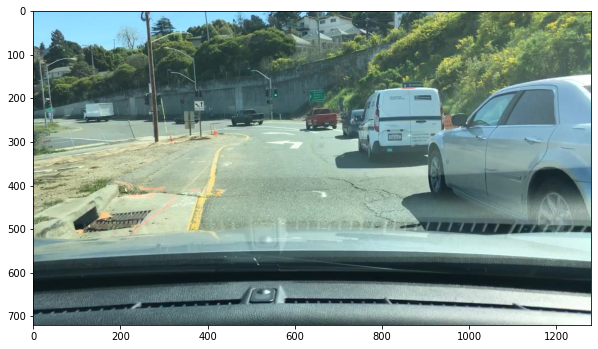

In [21]:
i = 140
img = imread('./test/'+str(i).zfill(3)+'.jpg')


copy_img = np.zeros((img.shape[0],img.shape[1]))
to_keep = []
#bbox_detection_list2.extend(bbox_detection_list3)
for x, y, dx, dy in boxes_dict[i+1]:
    copy_img[y:y+dy, x:x+dx] = 1
for x, y, dx, dy in boxes_dict[i]:
    if np.sum(copy_img[y:y+dy, x:x+dx])/(dx*dy) >= 0.3:
        to_keep.append([x, y, dx, dy])

to_keep = non_max_suppression(np.array(to_keep), overlapThresh=0.2)


fig, ax = plt.subplots(figsize=(10, 8))
for x, y, dx, dy in to_keep:

    rect = patches.Rectangle((x, y), dx, dy, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
ax.imshow(img)


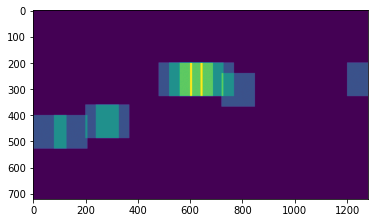

In [73]:
plt.imshow(pred_array_dict[i-3]+pred_array_dict[i-1]+pred_array_dict[i]+pred_array_dict[i+3])

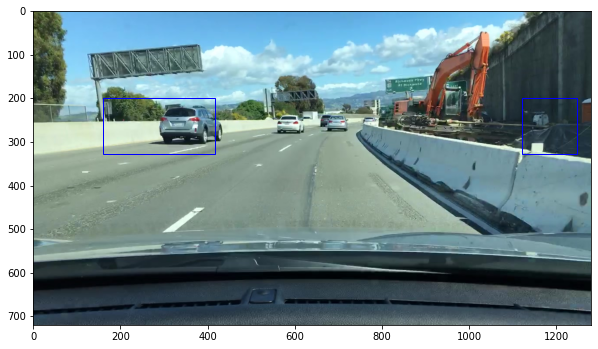

In [30]:
i = 12
img = imread('./test/'+str(i).zfill(3)+'.jpg')


copy_img = np.zeros((img.shape[0],img.shape[1]))
to_keep = []
#bbox_detection_list2.extend(bbox_detection_list3)
pred = (pred_array_dict[i+5]+pred_array_dict[i-3]+pred_array_dict[i-2]+pred_array_dict[i-1]+pred_array_dict[i]+pred_array_dict[i+3]+pred_array_dict[i+2])

to_keep = box_otsu(pred)


fig, ax = plt.subplots(figsize=(10, 8))
for x, y, dx, dy in to_keep:

    rect = patches.Rectangle((x, y), dx, dy, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
ax.imshow(img)


In [45]:
boxes_dict = pickle.load(open("data/features/boxes_dict.pkl", 'rb'))

In [24]:
from scipy.spatial import distance as dist
centroids_0= [(np.int32(x+dx/2), np.int32(y+dy/2)) for x,y,dx,dy in boxes_dict[1]]
to_remove = []
for i in range(len(centroids_0)):
    if centroids_0[i][0] < 200 or centroids_0[i][0] > 700 or centroids_0[i][1] < 100 or centroids_0[i][1] > 600:
        to_remove.append(i)
new_box = []
for j in range(len(centroids_0)):
        if j in to_remove:
            continue
        else:
            new_box.append(boxes_dict[1][j])

boxes_dict[1] = new_box

for h in range(1,202):
    boxes1 = boxes_dict[h]
    boxes2 = boxes_dict[h+1]
    if len(boxes1)==0 or len(boxes2)==0:
        continue

    centroids_i= [(np.int32(x+dx/2), np.int32(y+dy/2)) for x,y,dx,dy in boxes1]
    centroids_i_1= [(np.int32(x+dx/2), np.int32(y+dy/2)) for x,y,dx,dy in boxes2]
    to_remove = []
    to_add = []
    new_box = []
    
    D = dist.cdist(np.array(centroids_i), np.array(centroids_i_1))
    sorted_new = D.min(axis=0)
    sorted_old = D.min(axis=1)
    for i,val in enumerate(sorted_new):
        if val > 80:
            if centroids_i_1[i][0] > 100 and centroids_i_1[i][0] < 1000 and centroids_i_1[i][1] > 100 and centroids_i_1[i][1] < 600:
                to_remove.append(i)
    for i,val in enumerate(sorted_old):
        if val > 80:
            if centroids_i[i][0] > 100 and centroids_i[i][0] < 1000 and centroids_i[i][1] > 100 and centroids_i[i][1] < 600:
                to_add.append(i)

    for j in range(len(centroids_i_1)):
        if j in to_remove:
            continue
        else:
            new_box.append(boxes2[j])

    for j in range(len(centroids_i)):
        if j in to_add:
            new_box.append(boxes1[j])


    boxes_dict[h+1] = new_box
    
    

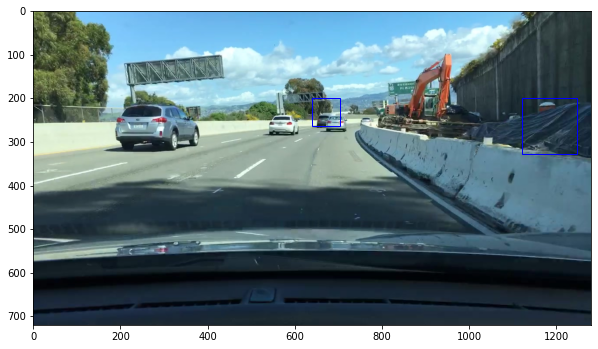

In [27]:
i = 10
img = imread('./test/'+str(i).zfill(3)+'.jpg')

pred_array = np.zeros((img.shape[0],img.shape[1]))
for box in boxes_dict[i]:
    pred_array[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]+=1

#to_keep = non_max_suppression(np.array(boxes_dict[i]), overlapThresh=0.3)
to_keep = box_otsu(pred_array)
fig, ax = plt.subplots(figsize=(10, 8))
for x, y, dx, dy in to_keep:

    rect = patches.Rectangle((x, y), dx, dy, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
ax.imshow(img)

In [28]:
from skimage.io import imread
import copy 

submission_df = pd.read_csv('sample_submission.csv')
submission_df = submission_df.drop(index = [0])
for i in range(1,203):
    name = 'test/'+str(i).zfill(3)+'.jpg'
    img = imread('./test/'+str(i).zfill(3)+'.jpg')
    #predictions = non_max_suppression(np.array(boxes_dict[i]), overlapThresh=0.2)
    pred_array = np.zeros((img.shape[0],img.shape[1]))
    for box in boxes_dict[i]:
        pred_array[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]+=1
    predictions = box_otsu(pred_array)
    predictions = np.array(predictions).ravel()
    final_pred = ' '.join(predictions.astype(str))

    line_to_add = pd.DataFrame([[name, final_pred]], columns = submission_df.columns)
    submission_df  = pd.concat([submission_df, line_to_add], axis = 0)

# convert prediction to the right format
preds = []
for i in range(submission_df.shape[0]):
    try:
        bbs = list(np.int32(submission_df.iloc[i].Predicted.split(" ")))
        bbs = np.array_split(bbs, len(bbs) / 4)

        mask = bounding_boxes_to_mask(bbs, 720, 1280)
        pred = run_length_encoding(mask)
        preds.append(pred)
    except:
        preds.append(pred)

submission_df.Predicted = preds

submission_df.to_csv('final_predictions.csv', index=False)

In [35]:
list(np.int32(submission_df.iloc[1].Predicted.split(" ")))

[1120, 200, 128, 128, 400, 200, 288, 128]